In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import imageio

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom
from smooth import Smoother, GenericSmoother, GenericSmootherWithMemory, Memory, compute_diffs

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [8]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

In [9]:
test_images = [lanelines.open_image(f, convert_to_rgb=True) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [10]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

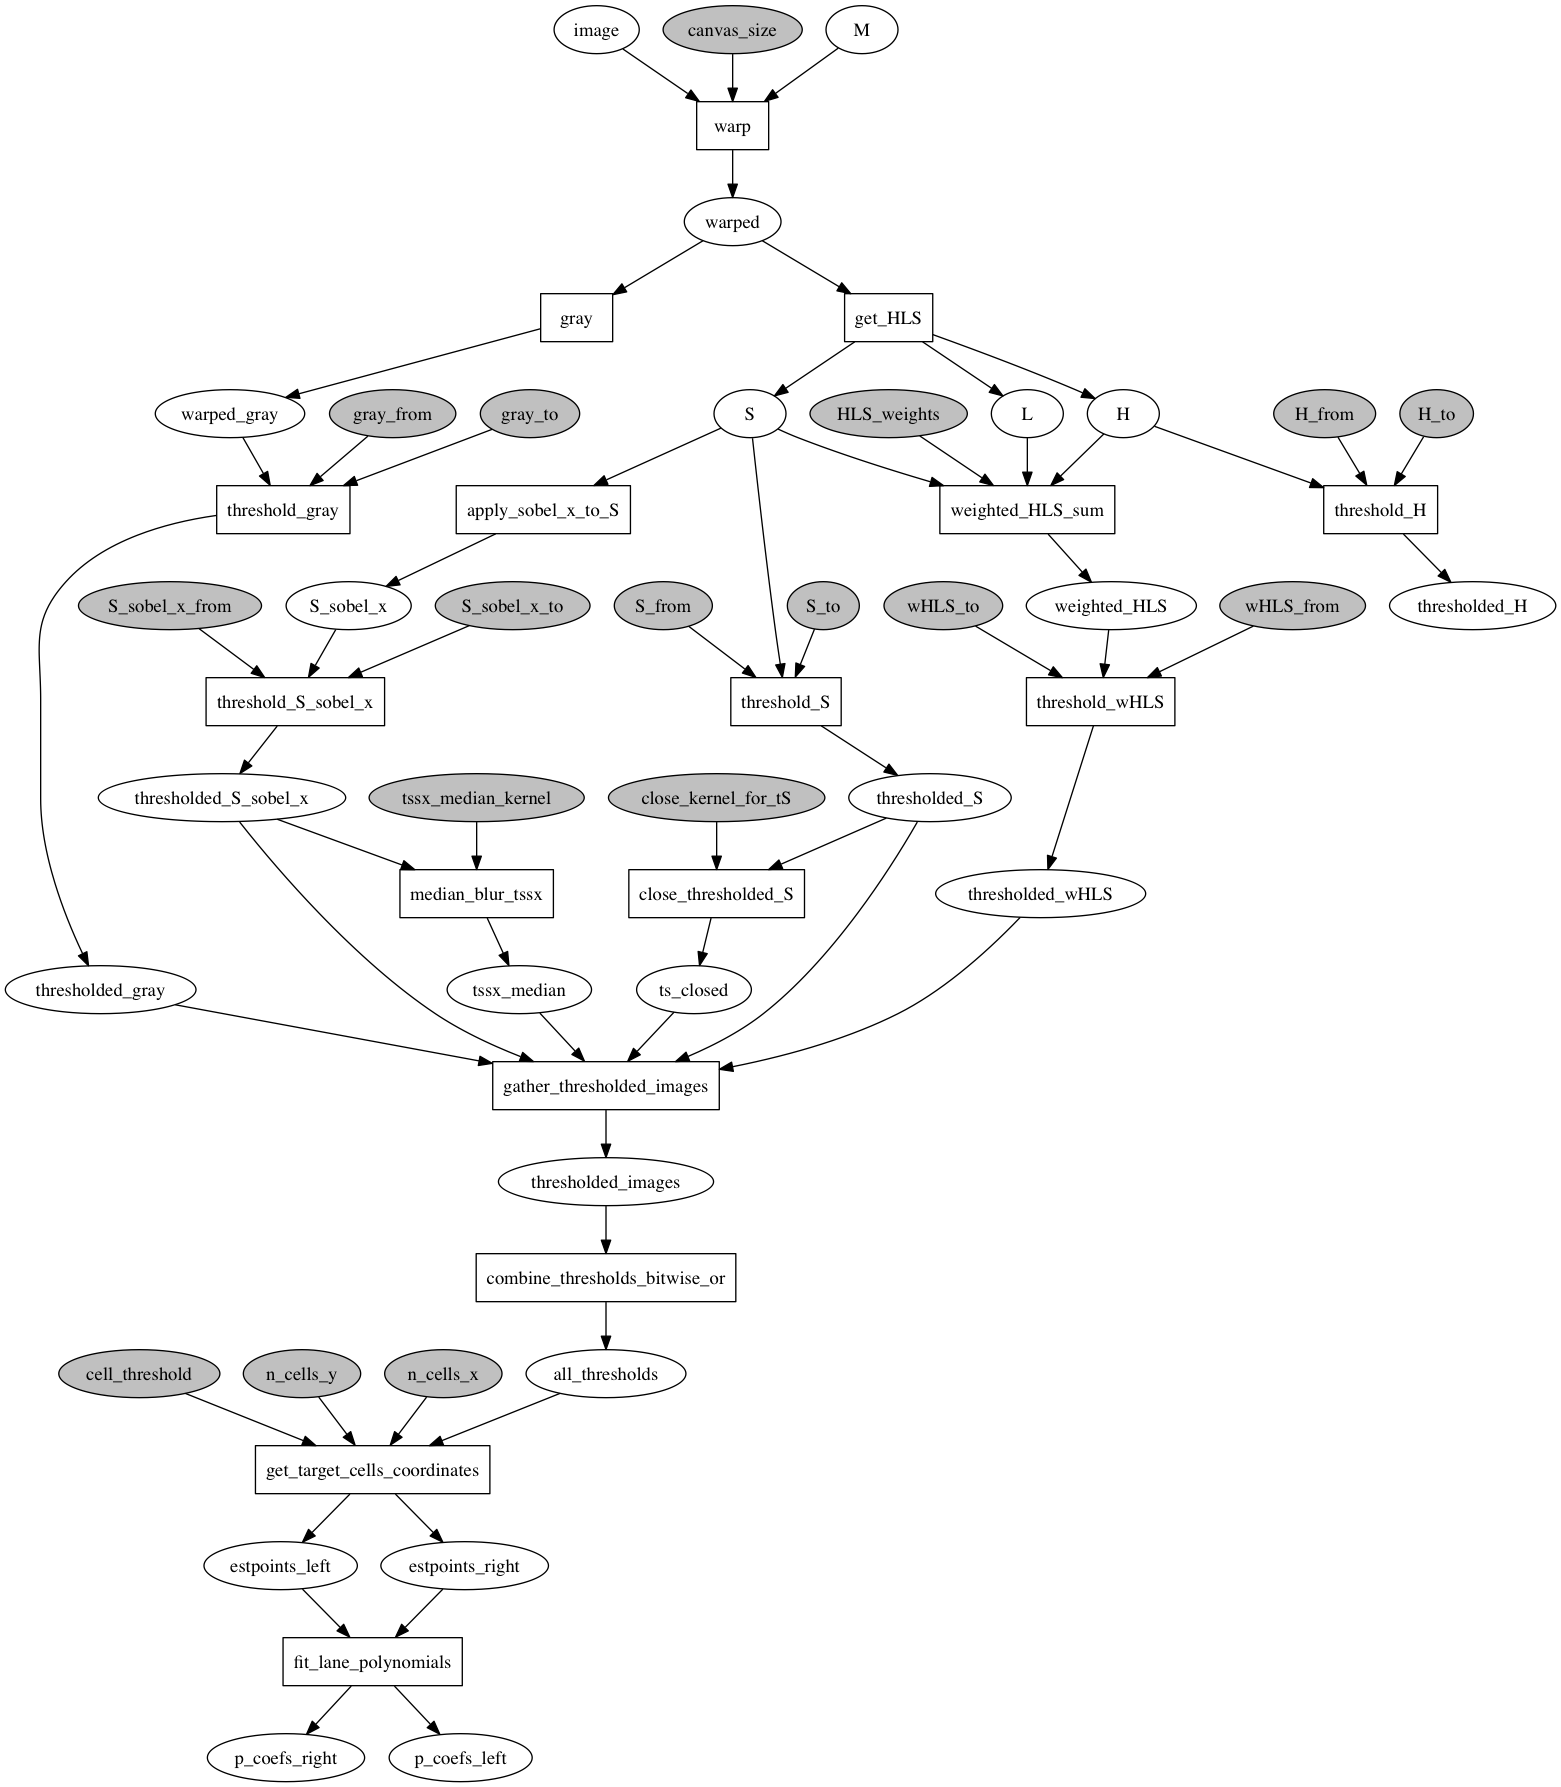

In [11]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

In [12]:
def lane_center(poly_x_left, poly_x_right, last_n=15):
    return poly_x_left[-last_n:] + (poly_x_right[-last_n:] - poly_x_left[-last_n:])

In [30]:
def create_processing_func_curvature(
    cg, 
    cg_params, 
    M, 
    M_inv, 
    memory_size=5,
    diff_threshold=int(1e4)
):

    runner = CompGraphRunner(cg, frozen_tokens=cg_params)

    tokens = ('p_coefs_left', 'p_coefs_right')
    thresholds = {
        'p_coefs_left': np.array([0.8e-4, 0.1, 80.]),
        'p_coefs_right': np.array([0.8e-4, 0.1, 80.])
    }
    
    mx, my = lanelines.pixel_to_meter_ratios_custom()
    
    coefs_smoother = Smoother(runner, M, tokens, thresholds)

    def curv(coefs):
        return lanelines.lane_curvature(coefs['p_coefs_left'], coefs['p_coefs_right'], mx, my, runner['canvas_size'])
        
    curv_smoother = GenericSmootherWithMemory(curv, diff_threshold, memory_size)
    
    def process(im):

        coefs = coefs_smoother(im)
        
        rendered_im = lanelines.render_lane(
            im, runner['warped'], coefs['p_coefs_left'], coefs['p_coefs_right'], M_inv
        )
        
        curvature = curv_smoother(coefs)
        
        return rendered_im, curvature

    return process

In [31]:
def get_curvatures_smoothed(first_n=None, memory_size=10):
    
    if first_n is None:
        first_n = len(video_rd)

    proc_func = create_processing_func_curvature(cg, cg_params, M, Minv, memory_size)
    video_rd = imageio.get_reader('project_video.mp4')

    curvatures_smoothed = []

    for i in range(first_n):
        frame = video_rd.get_data(i)
        rendered_im, curv_smoothed = proc_func(frame)

        curvatures_smoothed.append(curv_smoothed)
        
    return np.array(curvatures_smoothed)

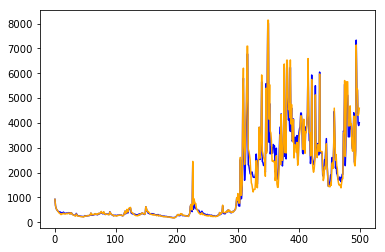

In [32]:
#curvatures_smoothed = get_curvatures_smoothed(first_n=50)
plt.plot( get_curvatures_smoothed(first_n=500, memory_size=10), color='blue' )
plt.plot( get_curvatures_smoothed(first_n=500, memory_size=5), color='orange' )

In [16]:
def get_curvatures_raw():
    
    last_y = cg_params['canvas_size'][1]

    video_rd = imageio.get_reader('project_video.mp4')
    runner = CompGraphRunner(cg, frozen_tokens=cg_params)
    
    curvatures = []
    for frame in video_rd:
        
        runner.run(image=frame, M=M)

        c1 = lanelines.curvature_poly2(runner['p_coefs_left'], last_y)
        c2 = lanelines.curvature_poly2(runner['p_coefs_right'], last_y)
        curvature = 0.5 * (c1 + c2)
        
        curvatures.append(curvature)
        
    return np.array(curvatures)

In [17]:
raw_curvartures = get_curvatures_raw()

diff_raw_curvartures = compute_diffs(raw_curvartures)

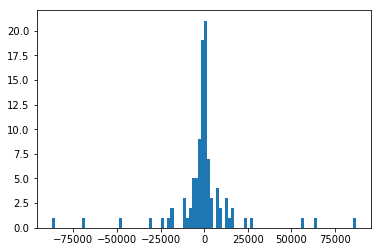

In [18]:
_ = plt.hist(diff_raw_curvartures[:100], bins=100)

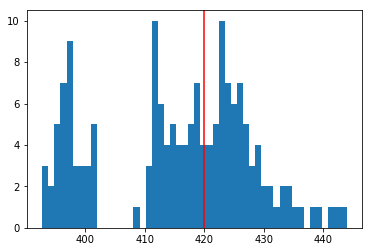

In [19]:
diffs_list = []

for im in test_images_undist:
    
    runner.run(image=im, M=M, Minv=Minv)
    
    poly_y, poly_x_left, poly_x_right = lanelines.get_lane_polynomials_points( runner['warped'], runner['p_coefs_left'], runner['p_coefs_right'] )
    
    diffs = lane_center(poly_x_left, poly_x_right, last_n=20)
    diffs_list.append(diffs)
    
all_diffs = np.concatenate(diffs_list)

_ = plt.hist(all_diffs, bins=50)
plt.axvline(420, color='r')

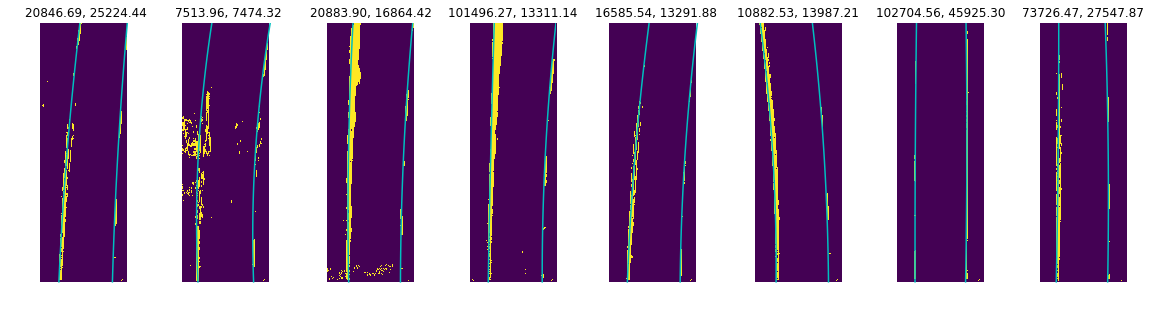

In [21]:
last_y = CANVAS_SZ[1]

plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')
    
    poly_y, poly_x_left, poly_x_right = lanelines.get_lane_polynomials_points( runner['warped'], runner['p_coefs_left'], runner['p_coefs_right'] )
    
    plt.plot(poly_x_left, poly_y, color='c')
    plt.plot(poly_x_right, poly_y, color='c')
    
    curv_left = lanelines.curvature_poly2(runner['p_coefs_left'], last_y)
    curv_right = lanelines.curvature_poly2(runner['p_coefs_right'], last_y)
    
    plt.title('{:.2f}, {:.2f}'.format(curv_left, curv_right))